In [8]:
!pip install --upgrade torch torchvision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.1/779.1 MB 3.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 21.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.1/168.1 MB 6.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.2/176.2 MB 9.7 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: triton
    Found existing installation: triton 2.2.0
    Uninstalling triton-2.2.0:
      Successfully uninstalled triton-2.2.0
  Attempting uninstall: nvidia-nccl-cu12
    Found existing installation: nvidia-nccl-cu12 2.19.3
    Uninstalling nvidia-nccl-cu12-2.19.3:
      Successfully uninstalled nvidia-nccl-cu12-2.19.3
  Attempting uninstall: torch
    Found existing installation: torch 2.2.2
    Uninstalling torch-2.2.2:
      Successfully uninstalled torch-2.2.2
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.17.2
    Uninstalling torchvision-0.17.2:
      Successfully

In [9]:
import numpy as np
import argparse
import random
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.utils.data
from scipy.io import loadmat
from model.GMVAE import *
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
#########################################################
## Input Parameters
#########################################################
parser = argparse.ArgumentParser(description='PyTorch Implementation of DGM Clustering')

## Used only in notebooks
parser.add_argument('-f', '--file',
                    help='Path for input file. First line should contain number of lines to search in')

## Dataset
parser.add_argument('--dataset', type=str, choices=['mnist'],
                    default='mnist', help='dataset (default: mnist)')
parser.add_argument('--seed', type=int, default=1, help='random seed (default: 1)')

## GPU
parser.add_argument('--cuda', type=int, default=1,
                    help='use of cuda (default: 1)')
parser.add_argument('--gpuID', type=int, default=0,
                    help='set gpu id to use (default: 0)')

## Training
parser.add_argument('--epochs', type=int, default=100,
                    help='number of total epochs to run (default: 200)')
parser.add_argument('--batch_size', default=64, type=int,
                    help='mini-batch size (default: 64)')
parser.add_argument('--batch_size_val', default=200, type=int,
                    help='mini-batch size of validation (default: 200)')
parser.add_argument('--learning_rate', default=1e-3, type=float,
                    help='learning rate (default: 0.001)')
parser.add_argument('--decay_epoch', default=-1, type=int,
                    help='Reduces the learning rate every decay_epoch')
parser.add_argument('--lr_decay', default=0.5, type=float,
                    help='Learning rate decay for training (default: 0.5)')

## Architecture
parser.add_argument('--num_classes', type=int, default=10,
                    help='number of classes (default: 10)')
parser.add_argument('--gaussian_size', default=64, type=int,
                    help='gaussian size (default: 64)')
parser.add_argument('--input_size', default=784, type=int,
                    help='input size (default: 784)')

## Partition parameters
parser.add_argument('--train_proportion', default=1.0, type=float,
                    help='proportion of examples to consider for training only (default: 1.0)')

## Gumbel parameters
parser.add_argument('--init_temp', default=1.0, type=float,
                    help='Initial temperature used in gumbel-softmax (recommended 0.5-1.0, default:1.0)')
parser.add_argument('--decay_temp', default=1, type=int,
                    help='Set 1 to decay gumbel temperature at every epoch (default: 1)')
parser.add_argument('--hard_gumbel', default=0, type=int,
                    help='Set 1 to use the hard version of gumbel-softmax (default: 1)')
parser.add_argument('--min_temp', default=0.5, type=float,
                    help='Minimum temperature of gumbel-softmax after annealing (default: 0.5)' )
parser.add_argument('--decay_temp_rate', default=0.013862944, type=float,
                    help='Temperature decay rate at every epoch (default: 0.013862944)')

## Loss function parameters
parser.add_argument('--w_gauss', default=2, type=float,
                    help='weight of gaussian loss (default: 1)')
parser.add_argument('--w_categ', default=1, type=float,
                    help='weight of categorical loss (default: 1)')
parser.add_argument('--w_rec', default=1, type=float,
                    help='weight of reconstruction loss (default: 1)')
parser.add_argument('--rec_type', type=str, choices=['bce', 'mse'],
                    default='bce', help='desired reconstruction loss function (default: bce)')

## Others
parser.add_argument('--verbose', default=0, type=int,
                    help='print extra information at every epoch.(default: 0)')

args = parser.parse_args()

In [11]:
## Random Seed
SEED = args.seed
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
if args.cuda:
  torch.cuda.manual_seed(SEED)

In [12]:
print("Loading mnist dataset...")

# load mnist data
train_dataset = datasets.MNIST('./mnist', train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.MNIST('./mnist', train=False, transform=transforms.ToTensor())

# print dataset shape
print('Train size: ', len(train_dataset), ' Test size: ', len(test_dataset))

Loading mnist dataset...
Train size:  60000  Test size:  10000


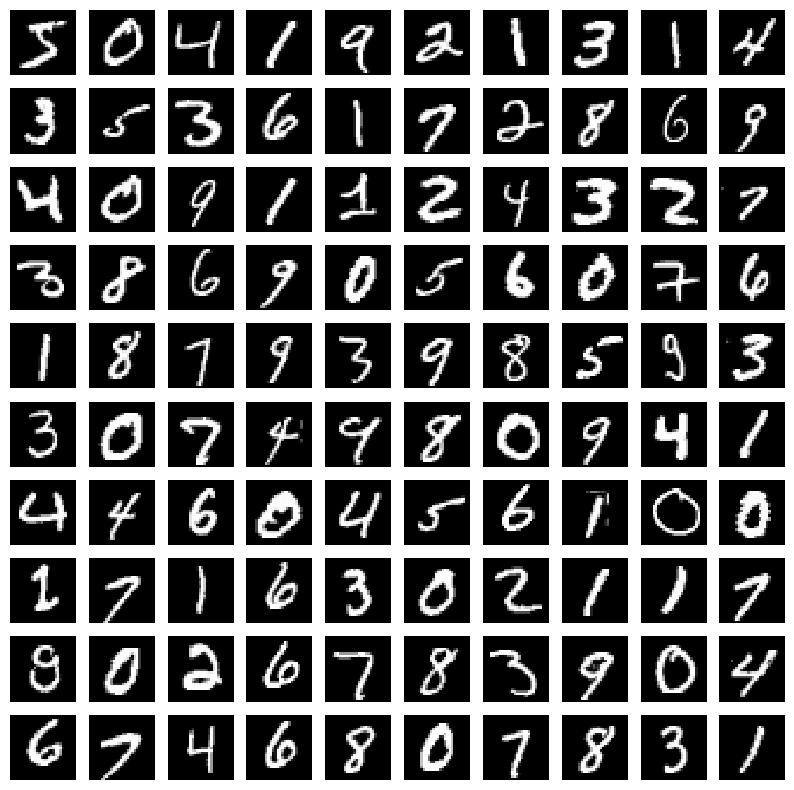

In [13]:
plt.figure(figsize=[10,10])
for i in range(0,100):
    plt.subplot(10,10,i+1)
    plt.imshow(np.reshape(train_dataset[i][0], (28,28)), interpolation='none',cmap=plt.get_cmap('gray'))
    plt.axis('off')

In [14]:
def partition_dataset(n, proportion=0.8):
  train_num = int(n * proportion)
  indices = np.random.permutation(n)
  train_indices, val_indices = indices[:train_num], indices[train_num:]
  return train_indices, val_indices

if args.train_proportion == 1.0:
  # we use all train dataset without partitioning
  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=args.batch_size_val, shuffle=False)
  val_loader = test_loader
else:
  # partition dataset according to train_proportion
  train_indices, val_indices = partition_dataset(len(train_dataset), args.train_proportion)
  # create data loaders for train, validation and test datasets
  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=args.batch_size, sampler=SubsetRandomSampler(train_indices))
  val_loader = torch.utils.data.DataLoader(train_dataset, batch_size=args.batch_size_val, sampler=SubsetRandomSampler(val_indices))
  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=args.batch_size_val, shuffle=False)


In [15]:
# Model Initialization
gmvae = GMVAE(args)

RuntimeError: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver.